# Convolutional Neural Network

Dataset in use: https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset/data

In [1]:
import os
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms, datasets
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
train_dir = "./dataset/Training"
val_dir = "./dataset/Validation"
input_size = (224, 224)
batch_size = 64

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
image_datasets = {
    'train': datasets.ImageFolder(root=train_dir, transform=transform['train']),
    'val': datasets.ImageFolder(root=val_dir, transform=transform['val'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False)
}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [7]:
class GenderClassifier(nn.Module):
    def __init__(self):
        super(GenderClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.bn1(nn.ReLU()(self.conv1(x))))
        x = self.pool(self.bn2(nn.ReLU()(self.conv2(x))))
        x = self.pool(self.bn3(nn.ReLU()(self.conv3(x))))
        x = x.view(-1, 64 * 28 * 28)
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [8]:
model = GenderClassifier()

model.to(device)
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [9]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch_idx, (inputs, labels) in enumerate(dataloaders['train']):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy for this batch
        predicted = torch.round(outputs)
        correct_predictions += torch.sum(predicted == labels.view_as(predicted)).item()
        total_predictions += labels.size(0)

        batch_loss = loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Phase: train, Batch: [{batch_idx+1}/{len(dataloaders["train"])}], Loss: {batch_loss:.4f}, Accuracy: {correct_predictions/total_predictions:.4f}')

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_accuracy = correct_predictions / total_predictions
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}')

Epoch [1/3], Phase: train, Batch: [1/730], Loss: 0.7090, Accuracy: 0.3438
Epoch [1/3], Phase: train, Batch: [2/730], Loss: 3.7680, Accuracy: 0.4141
Epoch [1/3], Phase: train, Batch: [3/730], Loss: 0.6949, Accuracy: 0.4844
Epoch [1/3], Phase: train, Batch: [4/730], Loss: 0.7357, Accuracy: 0.5156
Epoch [1/3], Phase: train, Batch: [5/730], Loss: 0.6586, Accuracy: 0.5312
Epoch [1/3], Phase: train, Batch: [6/730], Loss: 0.8393, Accuracy: 0.5260
Epoch [1/3], Phase: train, Batch: [7/730], Loss: 0.5729, Accuracy: 0.5536
Epoch [1/3], Phase: train, Batch: [8/730], Loss: 0.5955, Accuracy: 0.5703
Epoch [1/3], Phase: train, Batch: [9/730], Loss: 0.4987, Accuracy: 0.5903
Epoch [1/3], Phase: train, Batch: [10/730], Loss: 0.4911, Accuracy: 0.6062
Epoch [1/3], Phase: train, Batch: [11/730], Loss: 0.4133, Accuracy: 0.6236
Epoch [1/3], Phase: train, Batch: [12/730], Loss: 0.4873, Accuracy: 0.6341
Epoch [1/3], Phase: train, Batch: [13/730], Loss: 0.8432, Accuracy: 0.6454
Epoch [1/3], Phase: train, Batch: 

Epoch [1/3], Phase: train, Batch: [111/730], Loss: 0.2126, Accuracy: 0.8523
Epoch [1/3], Phase: train, Batch: [112/730], Loss: 0.2161, Accuracy: 0.8528
Epoch [1/3], Phase: train, Batch: [113/730], Loss: 0.3518, Accuracy: 0.8532
Epoch [1/3], Phase: train, Batch: [114/730], Loss: 0.3763, Accuracy: 0.8533
Epoch [1/3], Phase: train, Batch: [115/730], Loss: 0.2859, Accuracy: 0.8538
Epoch [1/3], Phase: train, Batch: [116/730], Loss: 0.2998, Accuracy: 0.8536
Epoch [1/3], Phase: train, Batch: [117/730], Loss: 0.1324, Accuracy: 0.8544
Epoch [1/3], Phase: train, Batch: [118/730], Loss: 0.1966, Accuracy: 0.8547
Epoch [1/3], Phase: train, Batch: [119/730], Loss: 0.3071, Accuracy: 0.8548
Epoch [1/3], Phase: train, Batch: [120/730], Loss: 0.2044, Accuracy: 0.8555
Epoch [1/3], Phase: train, Batch: [121/730], Loss: 0.2761, Accuracy: 0.8556
Epoch [1/3], Phase: train, Batch: [122/730], Loss: 0.1756, Accuracy: 0.8560
Epoch [1/3], Phase: train, Batch: [123/730], Loss: 0.5383, Accuracy: 0.8557
Epoch [1/3],

Epoch [1/3], Phase: train, Batch: [219/730], Loss: 0.2575, Accuracy: 0.8817
Epoch [1/3], Phase: train, Batch: [220/730], Loss: 0.1229, Accuracy: 0.8820
Epoch [1/3], Phase: train, Batch: [221/730], Loss: 0.1779, Accuracy: 0.8821
Epoch [1/3], Phase: train, Batch: [222/730], Loss: 0.2807, Accuracy: 0.8820
Epoch [1/3], Phase: train, Batch: [223/730], Loss: 0.1653, Accuracy: 0.8823
Epoch [1/3], Phase: train, Batch: [224/730], Loss: 0.2503, Accuracy: 0.8824
Epoch [1/3], Phase: train, Batch: [225/730], Loss: 0.1824, Accuracy: 0.8826
Epoch [1/3], Phase: train, Batch: [226/730], Loss: 0.2265, Accuracy: 0.8827
Epoch [1/3], Phase: train, Batch: [227/730], Loss: 0.2716, Accuracy: 0.8827
Epoch [1/3], Phase: train, Batch: [228/730], Loss: 0.2066, Accuracy: 0.8829
Epoch [1/3], Phase: train, Batch: [229/730], Loss: 0.3538, Accuracy: 0.8826
Epoch [1/3], Phase: train, Batch: [230/730], Loss: 0.1416, Accuracy: 0.8829
Epoch [1/3], Phase: train, Batch: [231/730], Loss: 0.2426, Accuracy: 0.8830
Epoch [1/3],

Epoch [1/3], Phase: train, Batch: [327/730], Loss: 0.0475, Accuracy: 0.8946
Epoch [1/3], Phase: train, Batch: [328/730], Loss: 0.2042, Accuracy: 0.8946
Epoch [1/3], Phase: train, Batch: [329/730], Loss: 0.2365, Accuracy: 0.8946
Epoch [1/3], Phase: train, Batch: [330/730], Loss: 0.1588, Accuracy: 0.8946
Epoch [1/3], Phase: train, Batch: [331/730], Loss: 0.0715, Accuracy: 0.8949
Epoch [1/3], Phase: train, Batch: [332/730], Loss: 0.1318, Accuracy: 0.8951
Epoch [1/3], Phase: train, Batch: [333/730], Loss: 0.2908, Accuracy: 0.8951
Epoch [1/3], Phase: train, Batch: [334/730], Loss: 0.2236, Accuracy: 0.8952
Epoch [1/3], Phase: train, Batch: [335/730], Loss: 0.0692, Accuracy: 0.8954
Epoch [1/3], Phase: train, Batch: [336/730], Loss: 0.2253, Accuracy: 0.8955
Epoch [1/3], Phase: train, Batch: [337/730], Loss: 0.3254, Accuracy: 0.8953
Epoch [1/3], Phase: train, Batch: [338/730], Loss: 0.2096, Accuracy: 0.8954
Epoch [1/3], Phase: train, Batch: [339/730], Loss: 0.1727, Accuracy: 0.8955
Epoch [1/3],

Epoch [1/3], Phase: train, Batch: [435/730], Loss: 0.1198, Accuracy: 0.9031
Epoch [1/3], Phase: train, Batch: [436/730], Loss: 0.1286, Accuracy: 0.9032
Epoch [1/3], Phase: train, Batch: [437/730], Loss: 0.2211, Accuracy: 0.9032
Epoch [1/3], Phase: train, Batch: [438/730], Loss: 0.2082, Accuracy: 0.9033
Epoch [1/3], Phase: train, Batch: [439/730], Loss: 0.1187, Accuracy: 0.9034
Epoch [1/3], Phase: train, Batch: [440/730], Loss: 0.1432, Accuracy: 0.9035
Epoch [1/3], Phase: train, Batch: [441/730], Loss: 0.2044, Accuracy: 0.9036
Epoch [1/3], Phase: train, Batch: [442/730], Loss: 0.1206, Accuracy: 0.9036
Epoch [1/3], Phase: train, Batch: [443/730], Loss: 0.1763, Accuracy: 0.9037
Epoch [1/3], Phase: train, Batch: [444/730], Loss: 0.2182, Accuracy: 0.9037
Epoch [1/3], Phase: train, Batch: [445/730], Loss: 0.1387, Accuracy: 0.9038
Epoch [1/3], Phase: train, Batch: [446/730], Loss: 0.1333, Accuracy: 0.9039
Epoch [1/3], Phase: train, Batch: [447/730], Loss: 0.3127, Accuracy: 0.9038
Epoch [1/3],

Epoch [1/3], Phase: train, Batch: [543/730], Loss: 0.0973, Accuracy: 0.9084
Epoch [1/3], Phase: train, Batch: [544/730], Loss: 0.1038, Accuracy: 0.9085
Epoch [1/3], Phase: train, Batch: [545/730], Loss: 0.1676, Accuracy: 0.9085
Epoch [1/3], Phase: train, Batch: [546/730], Loss: 0.2099, Accuracy: 0.9086
Epoch [1/3], Phase: train, Batch: [547/730], Loss: 0.1907, Accuracy: 0.9086
Epoch [1/3], Phase: train, Batch: [548/730], Loss: 0.1953, Accuracy: 0.9086
Epoch [1/3], Phase: train, Batch: [549/730], Loss: 0.2545, Accuracy: 0.9086
Epoch [1/3], Phase: train, Batch: [550/730], Loss: 0.1693, Accuracy: 0.9086
Epoch [1/3], Phase: train, Batch: [551/730], Loss: 0.0921, Accuracy: 0.9087
Epoch [1/3], Phase: train, Batch: [552/730], Loss: 0.1849, Accuracy: 0.9088
Epoch [1/3], Phase: train, Batch: [553/730], Loss: 0.1100, Accuracy: 0.9089
Epoch [1/3], Phase: train, Batch: [554/730], Loss: 0.1913, Accuracy: 0.9089
Epoch [1/3], Phase: train, Batch: [555/730], Loss: 0.2404, Accuracy: 0.9090
Epoch [1/3],

Epoch [1/3], Phase: train, Batch: [651/730], Loss: 0.1127, Accuracy: 0.9133
Epoch [1/3], Phase: train, Batch: [652/730], Loss: 0.0683, Accuracy: 0.9134
Epoch [1/3], Phase: train, Batch: [653/730], Loss: 0.0655, Accuracy: 0.9135
Epoch [1/3], Phase: train, Batch: [654/730], Loss: 0.0834, Accuracy: 0.9136
Epoch [1/3], Phase: train, Batch: [655/730], Loss: 0.1925, Accuracy: 0.9136
Epoch [1/3], Phase: train, Batch: [656/730], Loss: 0.1756, Accuracy: 0.9137
Epoch [1/3], Phase: train, Batch: [657/730], Loss: 0.2121, Accuracy: 0.9138
Epoch [1/3], Phase: train, Batch: [658/730], Loss: 0.0446, Accuracy: 0.9139
Epoch [1/3], Phase: train, Batch: [659/730], Loss: 0.1377, Accuracy: 0.9140
Epoch [1/3], Phase: train, Batch: [660/730], Loss: 0.1372, Accuracy: 0.9140
Epoch [1/3], Phase: train, Batch: [661/730], Loss: 0.1702, Accuracy: 0.9140
Epoch [1/3], Phase: train, Batch: [662/730], Loss: 0.0841, Accuracy: 0.9141
Epoch [1/3], Phase: train, Batch: [663/730], Loss: 0.2139, Accuracy: 0.9141
Epoch [1/3],

Epoch [2/3], Phase: train, Batch: [29/730], Loss: 0.0526, Accuracy: 0.9456
Epoch [2/3], Phase: train, Batch: [30/730], Loss: 0.1962, Accuracy: 0.9453
Epoch [2/3], Phase: train, Batch: [31/730], Loss: 0.1186, Accuracy: 0.9466
Epoch [2/3], Phase: train, Batch: [32/730], Loss: 0.1666, Accuracy: 0.9463
Epoch [2/3], Phase: train, Batch: [33/730], Loss: 0.0516, Accuracy: 0.9470
Epoch [2/3], Phase: train, Batch: [34/730], Loss: 0.2437, Accuracy: 0.9462
Epoch [2/3], Phase: train, Batch: [35/730], Loss: 0.0586, Accuracy: 0.9473
Epoch [2/3], Phase: train, Batch: [36/730], Loss: 0.1187, Accuracy: 0.9479
Epoch [2/3], Phase: train, Batch: [37/730], Loss: 0.0830, Accuracy: 0.9485
Epoch [2/3], Phase: train, Batch: [38/730], Loss: 0.1932, Accuracy: 0.9478
Epoch [2/3], Phase: train, Batch: [39/730], Loss: 0.1103, Accuracy: 0.9483
Epoch [2/3], Phase: train, Batch: [40/730], Loss: 0.0456, Accuracy: 0.9496
Epoch [2/3], Phase: train, Batch: [41/730], Loss: 0.1422, Accuracy: 0.9497
Epoch [2/3], Phase: train

Epoch [2/3], Phase: train, Batch: [138/730], Loss: 0.1868, Accuracy: 0.9514
Epoch [2/3], Phase: train, Batch: [139/730], Loss: 0.0747, Accuracy: 0.9517
Epoch [2/3], Phase: train, Batch: [140/730], Loss: 0.1386, Accuracy: 0.9516
Epoch [2/3], Phase: train, Batch: [141/730], Loss: 0.0903, Accuracy: 0.9516
Epoch [2/3], Phase: train, Batch: [142/730], Loss: 0.0908, Accuracy: 0.9515
Epoch [2/3], Phase: train, Batch: [143/730], Loss: 0.0754, Accuracy: 0.9517
Epoch [2/3], Phase: train, Batch: [144/730], Loss: 0.1030, Accuracy: 0.9516
Epoch [2/3], Phase: train, Batch: [145/730], Loss: 0.0567, Accuracy: 0.9518
Epoch [2/3], Phase: train, Batch: [146/730], Loss: 0.1211, Accuracy: 0.9516
Epoch [2/3], Phase: train, Batch: [147/730], Loss: 0.1216, Accuracy: 0.9513
Epoch [2/3], Phase: train, Batch: [148/730], Loss: 0.1402, Accuracy: 0.9513
Epoch [2/3], Phase: train, Batch: [149/730], Loss: 0.1035, Accuracy: 0.9514
Epoch [2/3], Phase: train, Batch: [150/730], Loss: 0.0813, Accuracy: 0.9516
Epoch [2/3],

Epoch [2/3], Phase: train, Batch: [246/730], Loss: 0.0758, Accuracy: 0.9517
Epoch [2/3], Phase: train, Batch: [247/730], Loss: 0.1896, Accuracy: 0.9515
Epoch [2/3], Phase: train, Batch: [248/730], Loss: 0.2015, Accuracy: 0.9512
Epoch [2/3], Phase: train, Batch: [249/730], Loss: 0.1840, Accuracy: 0.9512
Epoch [2/3], Phase: train, Batch: [250/730], Loss: 0.1268, Accuracy: 0.9511
Epoch [2/3], Phase: train, Batch: [251/730], Loss: 0.1026, Accuracy: 0.9512
Epoch [2/3], Phase: train, Batch: [252/730], Loss: 0.1110, Accuracy: 0.9513
Epoch [2/3], Phase: train, Batch: [253/730], Loss: 0.0511, Accuracy: 0.9515
Epoch [2/3], Phase: train, Batch: [254/730], Loss: 0.0924, Accuracy: 0.9516
Epoch [2/3], Phase: train, Batch: [255/730], Loss: 0.0432, Accuracy: 0.9518
Epoch [2/3], Phase: train, Batch: [256/730], Loss: 0.1298, Accuracy: 0.9518
Epoch [2/3], Phase: train, Batch: [257/730], Loss: 0.0645, Accuracy: 0.9520
Epoch [2/3], Phase: train, Batch: [258/730], Loss: 0.1730, Accuracy: 0.9519
Epoch [2/3],

Epoch [2/3], Phase: train, Batch: [354/730], Loss: 0.1460, Accuracy: 0.9538
Epoch [2/3], Phase: train, Batch: [355/730], Loss: 0.0234, Accuracy: 0.9539
Epoch [2/3], Phase: train, Batch: [356/730], Loss: 0.0960, Accuracy: 0.9539
Epoch [2/3], Phase: train, Batch: [357/730], Loss: 0.0433, Accuracy: 0.9540
Epoch [2/3], Phase: train, Batch: [358/730], Loss: 0.0876, Accuracy: 0.9540
Epoch [2/3], Phase: train, Batch: [359/730], Loss: 0.1933, Accuracy: 0.9540
Epoch [2/3], Phase: train, Batch: [360/730], Loss: 0.0284, Accuracy: 0.9542
Epoch [2/3], Phase: train, Batch: [361/730], Loss: 0.0749, Accuracy: 0.9542
Epoch [2/3], Phase: train, Batch: [362/730], Loss: 0.1005, Accuracy: 0.9542
Epoch [2/3], Phase: train, Batch: [363/730], Loss: 0.2250, Accuracy: 0.9542
Epoch [2/3], Phase: train, Batch: [364/730], Loss: 0.0504, Accuracy: 0.9543
Epoch [2/3], Phase: train, Batch: [365/730], Loss: 0.0386, Accuracy: 0.9544
Epoch [2/3], Phase: train, Batch: [366/730], Loss: 0.2611, Accuracy: 0.9543
Epoch [2/3],

Epoch [2/3], Phase: train, Batch: [462/730], Loss: 0.1744, Accuracy: 0.9534
Epoch [2/3], Phase: train, Batch: [463/730], Loss: 0.2037, Accuracy: 0.9533
Epoch [2/3], Phase: train, Batch: [464/730], Loss: 0.0778, Accuracy: 0.9533
Epoch [2/3], Phase: train, Batch: [465/730], Loss: 0.1179, Accuracy: 0.9533
Epoch [2/3], Phase: train, Batch: [466/730], Loss: 0.0768, Accuracy: 0.9533
Epoch [2/3], Phase: train, Batch: [467/730], Loss: 0.1490, Accuracy: 0.9534
Epoch [2/3], Phase: train, Batch: [468/730], Loss: 0.1355, Accuracy: 0.9534
Epoch [2/3], Phase: train, Batch: [469/730], Loss: 0.1005, Accuracy: 0.9534
Epoch [2/3], Phase: train, Batch: [470/730], Loss: 0.1799, Accuracy: 0.9534
Epoch [2/3], Phase: train, Batch: [471/730], Loss: 0.2670, Accuracy: 0.9533
Epoch [2/3], Phase: train, Batch: [472/730], Loss: 0.2323, Accuracy: 0.9532
Epoch [2/3], Phase: train, Batch: [473/730], Loss: 0.0915, Accuracy: 0.9532
Epoch [2/3], Phase: train, Batch: [474/730], Loss: 0.1266, Accuracy: 0.9532
Epoch [2/3],

Epoch [2/3], Phase: train, Batch: [570/730], Loss: 0.0447, Accuracy: 0.9532
Epoch [2/3], Phase: train, Batch: [571/730], Loss: 0.0747, Accuracy: 0.9532
Epoch [2/3], Phase: train, Batch: [572/730], Loss: 0.1715, Accuracy: 0.9532
Epoch [2/3], Phase: train, Batch: [573/730], Loss: 0.1539, Accuracy: 0.9531
Epoch [2/3], Phase: train, Batch: [574/730], Loss: 0.0980, Accuracy: 0.9531
Epoch [2/3], Phase: train, Batch: [575/730], Loss: 0.1186, Accuracy: 0.9531
Epoch [2/3], Phase: train, Batch: [576/730], Loss: 0.0660, Accuracy: 0.9532
Epoch [2/3], Phase: train, Batch: [577/730], Loss: 0.0453, Accuracy: 0.9532
Epoch [2/3], Phase: train, Batch: [578/730], Loss: 0.0558, Accuracy: 0.9533
Epoch [2/3], Phase: train, Batch: [579/730], Loss: 0.0491, Accuracy: 0.9533
Epoch [2/3], Phase: train, Batch: [580/730], Loss: 0.1187, Accuracy: 0.9533
Epoch [2/3], Phase: train, Batch: [581/730], Loss: 0.0389, Accuracy: 0.9534
Epoch [2/3], Phase: train, Batch: [582/730], Loss: 0.0462, Accuracy: 0.9535
Epoch [2/3],

Epoch [2/3], Phase: train, Batch: [678/730], Loss: 0.1264, Accuracy: 0.9535
Epoch [2/3], Phase: train, Batch: [679/730], Loss: 0.0527, Accuracy: 0.9536
Epoch [2/3], Phase: train, Batch: [680/730], Loss: 0.0844, Accuracy: 0.9536
Epoch [2/3], Phase: train, Batch: [681/730], Loss: 0.0891, Accuracy: 0.9536
Epoch [2/3], Phase: train, Batch: [682/730], Loss: 0.0691, Accuracy: 0.9537
Epoch [2/3], Phase: train, Batch: [683/730], Loss: 0.0554, Accuracy: 0.9537
Epoch [2/3], Phase: train, Batch: [684/730], Loss: 0.0545, Accuracy: 0.9537
Epoch [2/3], Phase: train, Batch: [685/730], Loss: 0.2411, Accuracy: 0.9537
Epoch [2/3], Phase: train, Batch: [686/730], Loss: 0.0687, Accuracy: 0.9538
Epoch [2/3], Phase: train, Batch: [687/730], Loss: 0.1289, Accuracy: 0.9537
Epoch [2/3], Phase: train, Batch: [688/730], Loss: 0.1113, Accuracy: 0.9537
Epoch [2/3], Phase: train, Batch: [689/730], Loss: 0.1395, Accuracy: 0.9537
Epoch [2/3], Phase: train, Batch: [690/730], Loss: 0.0635, Accuracy: 0.9537
Epoch [2/3],

Epoch [3/3], Phase: train, Batch: [56/730], Loss: 0.1594, Accuracy: 0.9674
Epoch [3/3], Phase: train, Batch: [57/730], Loss: 0.2064, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [58/730], Loss: 0.0965, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [59/730], Loss: 0.1139, Accuracy: 0.9661
Epoch [3/3], Phase: train, Batch: [60/730], Loss: 0.1032, Accuracy: 0.9661
Epoch [3/3], Phase: train, Batch: [61/730], Loss: 0.0604, Accuracy: 0.9662
Epoch [3/3], Phase: train, Batch: [62/730], Loss: 0.0803, Accuracy: 0.9665
Epoch [3/3], Phase: train, Batch: [63/730], Loss: 0.0933, Accuracy: 0.9665
Epoch [3/3], Phase: train, Batch: [64/730], Loss: 0.0904, Accuracy: 0.9668
Epoch [3/3], Phase: train, Batch: [65/730], Loss: 0.2075, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [66/730], Loss: 0.0856, Accuracy: 0.9664
Epoch [3/3], Phase: train, Batch: [67/730], Loss: 0.0227, Accuracy: 0.9669
Epoch [3/3], Phase: train, Batch: [68/730], Loss: 0.0944, Accuracy: 0.9669
Epoch [3/3], Phase: train

Epoch [3/3], Phase: train, Batch: [165/730], Loss: 0.1024, Accuracy: 0.9662
Epoch [3/3], Phase: train, Batch: [166/730], Loss: 0.1835, Accuracy: 0.9662
Epoch [3/3], Phase: train, Batch: [167/730], Loss: 0.1137, Accuracy: 0.9662
Epoch [3/3], Phase: train, Batch: [168/730], Loss: 0.1291, Accuracy: 0.9660
Epoch [3/3], Phase: train, Batch: [169/730], Loss: 0.1018, Accuracy: 0.9659
Epoch [3/3], Phase: train, Batch: [170/730], Loss: 0.0986, Accuracy: 0.9658
Epoch [3/3], Phase: train, Batch: [171/730], Loss: 0.0834, Accuracy: 0.9659
Epoch [3/3], Phase: train, Batch: [172/730], Loss: 0.0719, Accuracy: 0.9659
Epoch [3/3], Phase: train, Batch: [173/730], Loss: 0.0894, Accuracy: 0.9660
Epoch [3/3], Phase: train, Batch: [174/730], Loss: 0.0270, Accuracy: 0.9661
Epoch [3/3], Phase: train, Batch: [175/730], Loss: 0.1423, Accuracy: 0.9660
Epoch [3/3], Phase: train, Batch: [176/730], Loss: 0.1292, Accuracy: 0.9658
Epoch [3/3], Phase: train, Batch: [177/730], Loss: 0.0322, Accuracy: 0.9660
Epoch [3/3],

Epoch [3/3], Phase: train, Batch: [273/730], Loss: 0.0252, Accuracy: 0.9674
Epoch [3/3], Phase: train, Batch: [274/730], Loss: 0.0902, Accuracy: 0.9674
Epoch [3/3], Phase: train, Batch: [275/730], Loss: 0.0718, Accuracy: 0.9674
Epoch [3/3], Phase: train, Batch: [276/730], Loss: 0.0668, Accuracy: 0.9674
Epoch [3/3], Phase: train, Batch: [277/730], Loss: 0.0583, Accuracy: 0.9675
Epoch [3/3], Phase: train, Batch: [278/730], Loss: 0.0628, Accuracy: 0.9675
Epoch [3/3], Phase: train, Batch: [279/730], Loss: 0.1994, Accuracy: 0.9674
Epoch [3/3], Phase: train, Batch: [280/730], Loss: 0.0530, Accuracy: 0.9675
Epoch [3/3], Phase: train, Batch: [281/730], Loss: 0.2380, Accuracy: 0.9673
Epoch [3/3], Phase: train, Batch: [282/730], Loss: 0.0735, Accuracy: 0.9674
Epoch [3/3], Phase: train, Batch: [283/730], Loss: 0.0451, Accuracy: 0.9675
Epoch [3/3], Phase: train, Batch: [284/730], Loss: 0.0371, Accuracy: 0.9675
Epoch [3/3], Phase: train, Batch: [285/730], Loss: 0.0670, Accuracy: 0.9675
Epoch [3/3],

Epoch [3/3], Phase: train, Batch: [381/730], Loss: 0.1283, Accuracy: 0.9664
Epoch [3/3], Phase: train, Batch: [382/730], Loss: 0.1512, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [383/730], Loss: 0.0732, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [384/730], Loss: 0.0813, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [385/730], Loss: 0.0733, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [386/730], Loss: 0.1048, Accuracy: 0.9662
Epoch [3/3], Phase: train, Batch: [387/730], Loss: 0.0874, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [388/730], Loss: 0.0166, Accuracy: 0.9664
Epoch [3/3], Phase: train, Batch: [389/730], Loss: 0.0565, Accuracy: 0.9664
Epoch [3/3], Phase: train, Batch: [390/730], Loss: 0.0266, Accuracy: 0.9665
Epoch [3/3], Phase: train, Batch: [391/730], Loss: 0.2378, Accuracy: 0.9664
Epoch [3/3], Phase: train, Batch: [392/730], Loss: 0.0507, Accuracy: 0.9664
Epoch [3/3], Phase: train, Batch: [393/730], Loss: 0.1593, Accuracy: 0.9663
Epoch [3/3],

Epoch [3/3], Phase: train, Batch: [489/730], Loss: 0.0418, Accuracy: 0.9657
Epoch [3/3], Phase: train, Batch: [490/730], Loss: 0.0195, Accuracy: 0.9658
Epoch [3/3], Phase: train, Batch: [491/730], Loss: 0.0444, Accuracy: 0.9659
Epoch [3/3], Phase: train, Batch: [492/730], Loss: 0.1642, Accuracy: 0.9658
Epoch [3/3], Phase: train, Batch: [493/730], Loss: 0.0711, Accuracy: 0.9657
Epoch [3/3], Phase: train, Batch: [494/730], Loss: 0.2066, Accuracy: 0.9657
Epoch [3/3], Phase: train, Batch: [495/730], Loss: 0.0670, Accuracy: 0.9657
Epoch [3/3], Phase: train, Batch: [496/730], Loss: 0.0939, Accuracy: 0.9657
Epoch [3/3], Phase: train, Batch: [497/730], Loss: 0.1355, Accuracy: 0.9656
Epoch [3/3], Phase: train, Batch: [498/730], Loss: 0.1059, Accuracy: 0.9656
Epoch [3/3], Phase: train, Batch: [499/730], Loss: 0.0331, Accuracy: 0.9657
Epoch [3/3], Phase: train, Batch: [500/730], Loss: 0.0751, Accuracy: 0.9657
Epoch [3/3], Phase: train, Batch: [501/730], Loss: 0.0298, Accuracy: 0.9657
Epoch [3/3],

Epoch [3/3], Phase: train, Batch: [597/730], Loss: 0.0813, Accuracy: 0.9662
Epoch [3/3], Phase: train, Batch: [598/730], Loss: 0.1443, Accuracy: 0.9662
Epoch [3/3], Phase: train, Batch: [599/730], Loss: 0.0872, Accuracy: 0.9662
Epoch [3/3], Phase: train, Batch: [600/730], Loss: 0.0783, Accuracy: 0.9662
Epoch [3/3], Phase: train, Batch: [601/730], Loss: 0.0307, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [602/730], Loss: 0.0729, Accuracy: 0.9662
Epoch [3/3], Phase: train, Batch: [603/730], Loss: 0.0590, Accuracy: 0.9662
Epoch [3/3], Phase: train, Batch: [604/730], Loss: 0.0512, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [605/730], Loss: 0.1990, Accuracy: 0.9662
Epoch [3/3], Phase: train, Batch: [606/730], Loss: 0.0415, Accuracy: 0.9662
Epoch [3/3], Phase: train, Batch: [607/730], Loss: 0.0938, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [608/730], Loss: 0.1467, Accuracy: 0.9662
Epoch [3/3], Phase: train, Batch: [609/730], Loss: 0.0696, Accuracy: 0.9662
Epoch [3/3],

Epoch [3/3], Phase: train, Batch: [705/730], Loss: 0.0981, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [706/730], Loss: 0.0887, Accuracy: 0.9662
Epoch [3/3], Phase: train, Batch: [707/730], Loss: 0.0891, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [708/730], Loss: 0.1431, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [709/730], Loss: 0.0521, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [710/730], Loss: 0.0663, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [711/730], Loss: 0.0832, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [712/730], Loss: 0.0979, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [713/730], Loss: 0.0348, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [714/730], Loss: 0.0770, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [715/730], Loss: 0.0496, Accuracy: 0.9664
Epoch [3/3], Phase: train, Batch: [716/730], Loss: 0.1335, Accuracy: 0.9663
Epoch [3/3], Phase: train, Batch: [717/730], Loss: 0.0645, Accuracy: 0.9663
Epoch [3/3],

In [10]:
true_labels = []
predicted_labels = []

model.eval()

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(dataloaders['val']):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        predicted = (outputs >= 0.5).squeeze().long()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

In [11]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
classification_rep = classification_report(true_labels, predicted_labels, target_names=class_names)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[5743   98]
 [ 461 5345]]


In [12]:
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

      female       0.93      0.98      0.95      5841
        male       0.98      0.92      0.95      5806

    accuracy                           0.95     11647
   macro avg       0.95      0.95      0.95     11647
weighted avg       0.95      0.95      0.95     11647



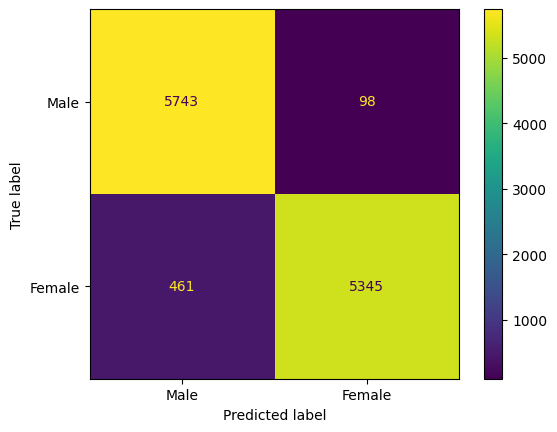

In [13]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['Male', 'Female'])
cm_display.plot()
plt.show()

In [14]:
torch.save(model.state_dict(), 'custom_model.pth')